In [ ]:
%%capture --no-stderr
!pip install -U langgraph==0.0.45 langchain-community langchain-anthropic tavily-python pandas langchain openai langchain-openai

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")


In [ ]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)
# Convert the flights to present time for our tutorial
conn = sqlite3.connect(local_file)
cursor = conn.cursor()

tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';", conn
).name.tolist()
tdf = {}
for t in tables:
    tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

example_time = pd.to_datetime(
    tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
).max()
current_time = pd.to_datetime("now").tz_localize(example_time.tz)
time_diff = current_time - example_time

tdf["bookings"]["book_date"] = (
    pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
    + time_diff
)

datetime_columns = [
    "scheduled_departure",
    "scheduled_arrival",
    "actual_departure",
    "actual_arrival",
]
for column in datetime_columns:
    tdf["flights"][column] = (
        pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
    )

for table_name, df in tdf.items():
    df.to_sql(table_name, conn, if_exists="replace", index=False)
del df
del tdf
conn.commit()
conn.close()

db = local_file  # We'll be using this local file as our DB in this tutorial

In [ ]:
persian_doc="""##سوالات مربوط به فاکتور

1. آیا می‌توانم فاکتور پرواز رزرو شده خود را دریافت کنم؟

بله، ما می‌توانیم تا 100 روز پس از استفاده کامل از بلیط/سند، تأییدیه رزرو جدید را به صورت رایگان برای شما ارسال کنیم. پس از این 100 روز، هزینه‌ای معادل 30.00 CHF برای هر تراکنش (حداکثر پنج تأییدیه E-ticket) دریافت می‌شود. تأییدیه E-ticket می‌تواند برای اهداف صدور فاکتور استفاده شود.

2. آیا باید پرواز خود را مجدداً تأیید کنم؟

خیر، نیازی به تأیید مجدد پروازهای SWISS نیست.

3. آیا می‌توانم بدون رزرو پرواز، وضعیت موجودی و قیمت‌ها را بررسی کنم؟

بله، می‌توانید وضعیت موجودی پرواز و قیمت‌ها را بدون نهایی کردن رزرو بررسی کنید. پرداخت تنها در مرحله آخر و پس از وارد کردن اطلاعات شخصی انجام می‌شود.

4. دسته‌بندی تعرفه‌های پرواز چیست؟

حروف B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (کلاس اقتصادی)، C,D,J,P,Z (کلاس تجاری) و A,F (کلاس اول) برای نشان دادن دسته‌بندی‌های قیمتی مختلف در کلاس‌های خدماتی مختلف استفاده می‌شود.

5. شرایط تعرفه بلیط‌های رزرو شده خود را کجا می‌توانم پیدا کنم؟

شرایط تعرفه بلیط‌های رزرو شده شما در طول فرآیند رزرو نمایش داده می‌شود. لطفاً توجه داشته باشید که شرایط تعرفه به زبان انگلیسی است و در طول فرآیند رزرو قابل مشاهده است.

6. چرا گاهی اوقات نام و نام وسط من بدون فاصله نوشته می‌شوند؟

## رزرو و لغو

1. چگونه می‌توانم رزرو خود را تغییر دهم؟
	* شماره بلیط باید با 724 (شماره بلیط/پلیت SWISS) شروع شود.
	* بلیط با معامله یا واچر پرداخت نشده باشد (استثنائاتی برای پرداخت‌های واچر وجود دارد؛ اگر بلیط به طور کامل با واچر پرداخت شده باشد، ممکن است تحت شرایط خاصی به صورت آنلاین قابل تغییر باشد. اگر به دلیل روش پرداخت امکان تغییر آنلاین وجود نداشته باشد، در طول فرآیند تغییر به شما اطلاع داده خواهد شد).
	* برای بلیط شما باید یک رزرو پرواز فعال وجود داشته باشد. در حال حاضر امکان تغییر آنلاین بلیط‌های باز یا بلیط‌هایی که بخش‌های پروازی مربوطه را ندارند وجود ندارد.
	* در حال حاضر تنها امکان تغییر بلیط‌های رفت (یک‌طرفه) یا بلیط‌های رفت و برگشت با مسیرهای پروازی تک (نقطه به نقطه) وجود دارد.
2. کدام بلیط‌ها/رزروها در حال حاضر به صورت آنلاین قابل تغییر نیستند؟
	* رزروهایی که شامل بخش‌های پروازی با سایر خطوط هوایی هستند
	* رزروهایی که شامل رزرواسیون هستند، جایی که بلیط هنوز صادر نشده است
	* رزروهایی با چندین بلیط معتبر برای یک شخص و مسیر
	* بلیط‌هایی با وضعیت غیر از O (باز) (A)
	* رزروهایی با بخش‌هایی با وضعیت غیر از OK (مثلاً شامل بخش‌های پروازی با وضعیت لیست انتظار) (HK|RR)
	* بلیط‌هایی که محاسبه تعرفه را نمایش نمی‌دهند (بلیط‌های IT)
	* رزروهایی که شامل خدمات ویژه هستند (مثلاً حمل حیوانات/حمل تجهیزات پزشکی/حمل تجهیزات ورزشی خاص و غیره)
	* بلیط‌هایی که بخشی از یک رزرو گروهی هستند
	* بلیط‌هایی که کلاس رزرو (RBD) آنها با کد تعرفه (FareBase) مطابقت ندارد
3. آیا مجاز به تغییر رزروهای آنلاین Redemption هستم؟
	* رزروهای Redemption هنوز نمی‌توانند در سایت swiss.com تغییر کنند.
4. چه تغییراتی می‌توانم در بلیط خود انجام دهم؟
	* می‌توانید پرواز و تاریخ‌های سفر را تغییر دهید. تغییر مبدا و مقصد یا تغییر نام به صورت آنلاین امکان‌پذیر نیست.
5. بعد از تغییرات آنلاین در برنامه سفر، می‌توانم تغییر دیگری انجام دهم؟
	* اگر شرایط تعرفه اجازه دهد، می‌توان چندین تغییر در برنامه سفر انجام داد.
6. آیا می‌توان پس از انجام رزرو، نام را تغییر داد؟
	* نام صحیح مسافر باید در رزرو وارد شود. نام و نام خانوادگی مسافر باید دقیقاً مانند مدارک سفر وارد شود. وارد کردن نام وسط اختیاری است و می‌تواند در فیلد نام اول اضافه شود. با این حال، محدودیت کاراکتری برای این فیلد وجود دارد.
	* نام اول و نام وسط شما توسط سیستم به صورت بدون فاصله ذخیره می‌شود. این یک خطا نیست و بر روی رزرو شما تأثیری ندارد.
	* هر گونه تغییر نام بعدی، از جمله افزودن نام به بلیط، مجاز نیست.
7. آیا امکان اعمال تغییرات تنها برای برخی از مسافران در همان رزرو وجود دارد؟
	* تغییرات همیشه برای همه مسافران همراه اعمال می‌شود. تغییر نام مسافر یا تعداد مسافران به صورت آنلاین امکان‌پذیر نیست.
8. تا چه زمانی قبل از پرواز می‌توان بلیط را به صورت آنلاین تغییر داد؟
	* حداقل زمان قبل از پرواز برای تغییرات آنلاین بستگی به فرودگاه مبدأ شما دارد. اگر از یک فرودگاه سوئیس پرواز می‌کنید، می‌توانید تا سه ساعت قبل از پرواز به صورت آنلاین تغییر دهید.
9. آیا تفاوت مالیات‌های فرودگاهی آنلاین در صورت ارزان‌تر بودن پرواز جدید بازپرداخت می‌شود؟
	* خیر، در حال حاضر بازپرداخت آنلاین امکان‌پذیر نیست.
10. چرا تغییرات در همان ارز بلیط انجام نمی‌شود؟
	* هرگونه محاسبات مربوط به تغییرات در ارز کشور مبدأ اصلی (Point of Commencement) انجام می‌شود.
11. آیا رزرو صندلی من در تغییرات در نظر گرفته می‌شود؟
	* بله، رزرو صندلی شما در تغییرات لحاظ خواهد شد.
12. آیا غذای ویژه من در تغییرات لحاظ خواهد شد؟
	* بله، غذای ویژه شما لحاظ خواهد شد.
13. آیا اطلاعات اضافی مسافر (APIS) من در تغییرات لحاظ خواهد شد؟
	* بله، جزئیات APIS شما لحاظ خواهد شد.
14. آیا بیمه مسافرتی دریافت شده از Europäische Reiseversicherung (بیمه مسافرتی اروپایی) از طریق SWISS در بلیط جدید لحاظ خواهد شد؟
	* بله، بیمه مسافرتی دریافت شده از طریق SWISS در بلیط جدید لحاظ خواهد شد و معتبر خواهد ماند.
15. آیا پس از تغییرات، مرجع رزرو جدیدی به من داده خواهد شد؟
	* خیر، مرجع رزرو شما پس از تغییرات ثابت می‌ماند.
16. آیا پس از تغییرات، شماره بلیط جدیدی به من داده خواهد شد؟
	* بله، پس از تغییرات شماره بلیط جدیدی به شما داده خواهد شد.
17. آیا می‌توانم پس از چک‌این آنلاین، رزرو خود را تغییر دهم؟
	* خیر، فقط بلیط‌هایی با وضعیت "باز" به صورت آنلاین قابل تغییر هستند.
18. من می‌خواهم یک رزرو پرواز را که بخشی از یک بسته خریداری شده از یک آژانس مسافرتی است تغییر دهم. چه مواردی را باید در نظر بگیرم؟
	* تغییرات انجام شده در سایت swiss.com محدود به رزرو پرواز است. هیچ تغییری در خدمات دیگر موجود در بسته شما (مثلاً هتل، خودرو اجاره‌ای و غیره) انجام نمی‌شود.
19. من می‌خواهم یک تغییر آنلاین در رزرو پروازی که از یک آژانس مسافرتی خریداری شده است انجام دهم. چه مواردی را باید در نظر بگیرم؟
	* می‌توانید رزرو پرواز خود را به صورت آنلاین تغییر دهید، اما آژانس مسافرتی شما به بلیط الکترونیکی جدید شما دسترسی نخواهد داشت.



## پلتفرم رزرو

1. چرا دیگر نمی‌توانم تمام رزروهای خود را در پروفایل خود ببینم؟
پاسخ: رزروهایی که قبل از 28.10.2021 از طریق پروفایل شما در swiss.com یا در اپلیکیشن SWISS انجام شده‌اند، دیگر قابل مشاهده نیستند. شما می‌توانید در صورت لزوم آنها را دوباره اضافه کنید.
2. چرا دیگر نمی‌توانم رزروهای افراد دیگر، مانند دوستان و خانواده، را در پروفایل خود ببینم؟
پاسخ: اگر می‌خواهید رزروهای اشخاص ثالث را به پروفایل خود اضافه کنید، لطفاً از تلفن همراه خود استفاده کنید. از طریق دسکتاپ (کامپیوتر و لپ‌تاپ) و تبلت، می‌توانید رزروهای اشخاص ثالث را به پروفایل خود اضافه کنید تنها در صورتی که رزرو مشترکی با شما به عنوان مالک پروفایل باشد.
3. کجا می‌توانم اطلاعات مربوط به کلاس رزرو را برای یک نرخ ببینم؟
پاسخ: از طریق دسکتاپ (کامپیوتر و لپ‌تاپ) و تبلت، می‌توانید اطلاعات مربوط به کلاس رزرو برای یک نرخ را به‌طور مستقیم در نتایج پرواز پیدا کنید.
4. کجا می‌توانم جزئیات نقشه صندلی‌ها برای یک پرواز را ببینم؟
پاسخ: از طریق دسکتاپ (کامپیوتر و لپ‌تاپ) و تبلت، می‌توانید نقشه صندلی‌ها برای یک پرواز را به‌طور مستقیم در نتایج پرواز پیدا کنید.
5. چگونه می‌توانم یک ارتقاء ترتیب دهم؟
پاسخ: از طریق دسکتاپ (کامپیوتر و لپ‌تاپ) و تبلت، می‌توانید بعد از اتمام موفقیت‌آمیز رزرو خود، از طریق پروفایل → رزروهای من → ویرایش رزرو → ارتقاء برای این پرواز، یک ارتقاء ترتیب دهید.
6. چگونه می‌توانم برای بیش از نه مسافر رزرو ترتیب دهم؟
پاسخ: شما می‌توانید برای بیش از نه نفر از طریق فرم رزرو گروهی ما رزرو ترتیب دهید.
7. چرا داده‌های کارت اعتباری که در اپلیکیشن SWISS ذخیره کرده‌ام، در نسخه دسکتاپ و تبلت swiss.com نیز دیده نمی‌شود؟
پاسخ: ذخیره داده‌های کارت اعتباری بستگی به دستگاهی دارد که از آن استفاده می‌کنید. داده‌های کارت اعتباری که در پروفایل خود از طریق دسکتاپ (کامپیوتر و لپ‌تاپ) یا تبلت ذخیره کرده‌اید، در تلفن همراه شما در دسترس نیست و بالعکس.
8. دیگر نمی‌توانم از برخی از قابلیت‌ها و خدمات از طریق تلفن همراه خود استفاده کنم. چه کاری می‌توانم انجام دهم؟
پاسخ: قابلیت‌ها و خدمات زیر موقتاً فقط از طریق دسکتاپ (کامپیوتر و لپ‌تاپ) و تبلت در دسترس هستند: بازخرید واچرها و کدهای تبلیغاتی، رزرو پروازهای چندمسیره، انجام تغییرات.
9. تا چه حد می‌توانم از پیشنهاد گروهی شرکت‌های هواپیمایی Lufthansa Group استفاده کنم؟
پاسخ: شما می‌توانید از تمامی پروازهای ارائه شده توسط تمامی شرکت‌های هواپیمایی گروه Lufthansa انتخاب کنید.
10. اگر سوالات بیشتری دارم یا نیاز به پشتیبانی دارم چه باید بکنم؟
پاسخ: می‌توانید با تیم پشتیبانی مشتریان ما تماس بگیرید.

## سفارش فاکتور
اگر برای مقاصد شخصی یا تجاری نیاز به فاکتور دارید، بیشتر کشورها تأییدیه بلیط الکترونیکی را به عنوان فاکتور قبول می‌کنند. برای کشورهایی که نیازهای خاصی دارند، می‌توان از فرم‌هایی که برای این منظور موجود است، فاکتور سفارش داد.

استفاده از تأییدیه بلیط الکترونیکی به عنوان فاکتور
تأییدیه بلیط الکترونیکی شما در بیشتر کشورها، از جمله سوئیس، به عنوان رسید به رسمیت شناخته می‌شود و می‌تواند برای بازپرداخت هزینه‌ها و ارسال اظهارنامه مالیاتی استفاده شود.

شما می‌توانید تأییدیه بلیط الکترونیکی خود را در پروفایل خود تحت بخش "رزروها" از طریق لینک "اسناد الکترونیکی (فاکتور)" یا از طریق لینک "رسید مسافر" سفارش دهید.

سفارش فاکتور پس از رزرو
اگر در تاریخ بعدی متوجه شدید که به فاکتور نیاز دارید، ما می‌توانیم تأییدیه رزرو جدیدی را تا 90 روز پس از استفاده کامل از بلیط/سند به صورت رایگان برای شما ارسال کنیم. پس از این دوره 90 روزه، برای هر تأییدیه هزینه‌ای معادل 30 CHF دریافت می‌شود (حداکثر پنج تأییدیه بلیط الکترونیکی).

فاکتورهای مربوط به یونان، هند، ایتالیا یا اسپانیا
برای پروازهایی که از یونان، هند، ایتالیا یا اسپانیا آغاز می‌شوند، ما می‌توانیم فاکتورهای ویژه‌ای را بنا به درخواست صادر کنیم. شما می‌توانید در این کشورها در صورتی که اطلاعات ارائه شده در بلیط الکترونیکی شما کافی نباشد، درخواست فاکتور کنید.


## کارت‌های اعتباری

شماره امنیتی کارت

برای امن‌تر کردن پرداخت‌های آنلاین با کارت‌های اعتباری یا نقدی، ما از شما می‌خواهیم که شماره امنیتی کارت را برای رزروهای آنلاین وارد کنید. این کد صحت اطلاعات کارت اعتباری/نقدی را بررسی می‌کند.

American Express

اگر از کارت American Express استفاده می‌کنید، شماره امنیتی 4 رقمی است که بالای شماره کارت اعتباری در جلوی کارت نمایش داده شده است.

MasterCard

اگر از کارت Mastercard (کارت اعتباری یا نقدی) استفاده می‌کنید، شماره امنیتی 3 رقمی است که در پشت کارت و در جایی که امضا قرار دارد نمایش داده شده است.

Visa

اگر از کارت Visa استفاده می‌کنید، شماره امنیتی 3 رقمی است که در پشت کارت و در جایی که امضا قرار دارد نمایش داده شده است.

Diners

اگر از کارت Diners استفاده می‌کنید، شماره امنیتی 3 رقمی است که در پشت کارت و در جایی که امضا قرار دارد نمایش داده شده است.

JBC

اگر از کارت JCB استفاده می‌کنید، شماره امنیتی 3 رقمی است که در پشت کارت و در جایی که امضا قرار دارد نمایش داده شده است.

China Union Pay

اگر از کارت اعتباری China Union Pay استفاده می‌کنید، شماره امنیتی 3 رقمی در قسمت امضا در پشت کارت نمایش داده شده است.


## امنیت کارت

استانداردهای امنیت پرداخت
براساس یک دستورالعمل جدید اتحادیه اروپا در مورد خدمات پرداخت، ما استانداردهای امنیت پرداخت خود را افزایش داده‌ایم که محیطی حتی امن‌تر برای تراکنش‌های آنلاین در سراسر کشورهای اروپایی فراهم می‌کند.

ما از استاندارد امنیت داده‌های صنعت کارت‌های پرداخت پیروی می‌کنیم که قوانین مربوط به نحوه ذخیره، انتقال و پردازش داده‌های پرداخت را تعریف می‌کند، به ویژه در مورد تراکنش‌های کارت‌های اعتباری و نقدی. این همچنین به این معنی است که تمام داده‌های پرداخت شما با بالاترین استانداردهای امنیتی رمزگذاری شده است.

احراز هویت 3-D Secure
برای تقویت بیشتر امنیت، احراز هویت 3-D Secure اکنون برای همه کارت‌های اعتباری و نقدی صادر شده در منطقه اقتصادی اروپا (EEA) الزامی است. این مرحله اضافی احراز هویت پرداخت‌های امن را تضمین می‌کند و خطر تقلب را کاهش می‌دهد.

فرآیند 3-D Secure چگونه کار می‌کند؟
اگر تاکنون این کار را انجام نداده‌اید، باید کارت اعتباری و نقدی خود را برای این فرآیند ثبت کنید.

از طریق وب‌سایت بانکی که کارت اعتباری یا نقدی شما را صادر کرده است ثبت‌نام کنید. این فرآیند می‌تواند از بانکی به بانک دیگر متفاوت باشد.
برای تکمیل تراکنش خود، در صورت اعمال 3-D Secure به پرداخت شما، به وب‌سایت بانک برای این احراز هویت اضافی هدایت خواهید شد.
Falls Sie weitere Fragen zur Registrierung Ihrer Karten für 3-D Secure haben, wenden Sie sich bitte direkt an Ihre Bank.
اگر سوالات بیشتری در مورد ثبت‌نام کارت‌های خود برای 3-D Secure دارید، لطفاً مستقیماً با بانک یا شرکت صادرکننده کارت خود تماس بگیرید.


## پرداخت از طریق فاکتور
چه کسی می‌تواند از گزینه "پرداخت از طریق فاکتور" استفاده کند؟
شما باید بالای 18 سال سن داشته باشید و مقیم سوئیس یا شاهزاده‌نشین لیختن‌اشتاین باشید. علاوه بر این، این گزینه پرداخت فقط برای پروازهای از سوئیس در دسترس است.

اسکن شناسه دقیقا چه چیزی را بررسی می‌کند و این فرآیند کجا انجام می‌شود؟
اسکن شناسه و مقایسه با یک عکس سلفی از تقلب جلوگیری می‌کند و اطمینان می‌دهد که شخصی که پرواز را رزرو کرده است همان دریافت‌کننده فاکتور است و هیچ سرقت هویتی صورت نگرفته است. برای این منظور، شما یک لینک از طریق پیامک به گوشی هوشمند خود دریافت خواهید کرد. شما قادر خواهید بود مدارک خود را آپلود کرده و از طریق این لینک خود را شناسایی کنید.

آیا باید اسکن شناسه را برای هر رزرو انجام دهم؟
خیر، زمانی که اسکن شناسه را با موفقیت انجام دادید، نیازی به انجام مجدد آن برای رزروهای بعدی نیست.

چرا اسکن شناسه من ناموفق بود؟
لطفاً در هنگام انجام اسکن شناسه به نکات زیر توجه کنید: عکس‌ها باید واضح، به‌خوبی نوردهی شده و از بازتاب‌ها خودداری شود. مدارک را نپوشانید. یک عکس جدید از خود بگیرید.

آیا می‌توانم اسکن شناسه ناموفق را تکرار کنم؟
بله، اگر مدارک شما شناسایی نشدند، می‌توانید اسکن شناسه را تکرار کنید.

چه دلایلی می‌تواند برای عدم تایید گزینه "پرداخت از طریق فاکتور" وجود داشته باشد؟
برای گزینه "پرداخت از طریق فاکتور"، شریک ما POWERPAY یک بررسی آنلاین انجام می‌دهد. این بررسی ممکن است به دلایل مختلفی مانند اعتبار سنجی، اطلاعات متناقض یا فاکتورهای پرداخت نشده POWERPAY نتیجه منفی داشته باشد. شما می‌توانید اطلاعات دقیق‌تر در مورد این دلایل را در وب‌سایت ​POWERPAY پیدا کنید.

چگونه و چه زمانی فاکتور POWERPAY را دریافت خواهم کرد؟
فاکتورها توسط POWERPAY صادر می‌شوند. شما یک فاکتور فردی از طریق ایمیل در حدود 24 تا 48 ساعت دریافت خواهید کرد. این فاکتور به صورت رایگان صادر می‌شود. هنگامی که فاکتور فردی به‌موقع پرداخت شود، هیچ هزینه‌ای دریافت نمی‌شود. پس از آن، مبالغ باقی‌مانده از فاکتورهای فردی که قبلاً دریافت کرده‌اید به یک صورت‌حساب حساب ترکیب می‌شود. شما این صورت‌حساب را حدوداً در اواسط ماه بعد به صورت یک فاکتور ماهانه از طریق پست دریافت خواهید کرد، به همراه یک فیش پرداخت. هزینه صدور فاکتور ماهانه 2.90 CHF است.

مدت زمان پرداخت چقدر است و هزینه‌های یادآوری برای عدم پرداخت چقدر است؟
فاکتور فردی: فاکتور باید ظرف 15 روز از دریافت ایمیل پرداخت شود. پرداخت از طریق بانکداری آنلاین انجام خواهد شد. پرداخت‌های انجام شده در صندوق پستی هزینه‌های شخص ثالث را به همراه دارد.
فاکتور ماهانه: مهلت پرداخت همیشه پایان ماه با فیش پرداخت است.
آیا پرداخت جزئی ممکن است؟
بله، پرداخت جزئی برای هر دو فاکتور فردی و ماهانه ممکن است. شما می‌توانید تصمیم بگیرید که بین 10٪ تا 100٪ از مبلغ کل را پرداخت کنید.

چه زمانی هزینه یادآوری به وجود می‌آید و چقدر هزینه دارد؟
اگر حداقل پرداخت فاکتور ماهانه دیر انجام شود، POWERPAY برای یادآوری اول 15 CHF و برای یادآوری دوم 25 CHF هزینه دریافت می‌کند.

چگونه می‌توانم بازپرداخت را دریافت کنم اگر بلیطم را لغو کنم؟
این بستگی به زمانی دارد که لغو را انجام می‌دهید.

اگر فاکتور قبلاً پرداخت شده باشد، بازپرداخت مربوطه را از طریق انتقال بانکی دریافت خواهید کرد.
اگر SWISS بتواند POWERPAY را از لغو قبل از پایان دوره پرداخت مطلع کند و اگر فاکتور پرداخت نشده یا فقط بخشی از آن پرداخت شده باشد، POWERPAY یک فاکتور فردی جدید با مبلغ جدید و دوره پرداخت جدید برای شما ارسال خواهد کرد اگر هنوز مبلغی باقی‌مانده باشد.
اگر SWISS بتواند POWERPAY را تنها پس از پایان دوره پرداخت مطلع کند و اگر فاکتور پرداخت نشده یا فقط بخشی از آن پرداخت شده باشد، گروه MF یک فاکتور ماهانه با هزینه‌های اضافی 2.90 CHF منهای مبلغ بازپرداختی برای شما ارسال خواهد کرد.

آیا باید فاکتور را به‌طور کامل پرداخت کنم قبل از سوار شدن به پروازم؟
خیر، شما می‌توانید بدون توجه به اینکه فاکتور POWERPAY خود را پرداخت کرده‌اید یا نه، سوار پرواز خود شوید.

آیا سوالی در مورد فاکتور خود دارید؟
اگر سوالی در مورد فاکتورها دارید، لطفاً با خدمات مشتری POWERPAY تماس بگیرید.

ایمیل: info@powerpay.ch

خط تلفن: +41 58 806 06 22

خدمات مشتری در روزهای دوشنبه تا جمعه از ساعت 8:00 تا 17:00 در دسترس است.

آیا می‌توانم آدرس تجاری خود را برای پرداخت‌ها ارائه دهم؟
خریدها در حساب فقط با ارائه آدرس خصوصی شما انجام می‌شود.


## سوالات متداول: پرداخت
چه مزایایی دارم اگر از گزینه تبدیل ارز استفاده کنم؟
استفاده از گزینه تبدیل ارز به شما مزایای زیر را می‌دهد:

شما تصمیم می‌گیرید که کدام ارز به کارت اعتباری شما شارژ شود.
نرخ ارز روزانه نمایش داده می‌شود و برای پرداخت تضمین شده است.
شرکت‌های کارت اعتباری معمولاً هزینه اضافی برای خریدهای انجام شده در ارزهای خارجی دریافت می‌کنند (هزینه ارز خارجی). این مورد در صورتی که به ارز کارت اعتباری خود پرداخت کنید، اعمال نمی‌شود.

چه کسی می‌تواند از گزینه تبدیل ارز بهره‌مند شود؟
گزینه پرداخت در یک ارز دیگر فقط زمانی در دسترس است که از طریق swiss.com رزرو کنید.

این سرویس نمی‌تواند برای تغییر پروازها، ارتقاءهای بعدی یا خدمات اضافی (مانند مورد اضافی چمدان و غیره) یا برای خرید بلیط‌هایی که از طریق کانال‌های مختلف رزرو شده‌اند، استفاده شود. این موارد به ارز اصلی فرودگاه مبدا شارژ می‌شوند.

چه نرخی برای تبدیل استفاده می‌شود؟
مبلغ کل تبدیل شده براساس نرخ‌های روزانه بانک سلطنتی اسکاتلند (RBS) محاسبه می‌شود. لطفاً توجه داشته باشید که نرخ تبدیل می‌تواند برای رزروهای جدید یا استعلامات رزرو انجام شده از طریق swiss.com متغیر باشد.

نرخ تبدیل در زمان تکمیل رزرو نهایی است. این نرخ هم در swiss.com و هم در تاییدیه نمایش داده می‌شود.

آیا هزینه‌های دیگری برای کارت اعتباری وجود دارد؟
برخی از بانک‌ها ممکن است در موارد خاص هزینه‌های اضافی دریافت کنند. SWISS هیچ تأثیری بر این هزینه‌ها ندارد.

برای بازپرداخت‌ها از چه ارزی استفاده می‌شود؟
بازپرداخت‌ها همیشه به ارز بلیط صادر شده انجام می‌شود.


## سوالات متداول: مفهوم کرایه اروپایی
آیا ممکن است یک کرایه خاص در کلاس اقتصادی به طور کامل رزرو شده باشد؟
خیر. تا زمانی که هنوز صندلی‌هایی در کلاس اقتصادی وجود داشته باشد، هر سه کرایه کلاس اقتصادی همیشه در هر کلاس رزرو موجود خواهد بود.

آیا کرایه‌های SWISS می‌توانند در پروازهای کدشیر با خطوط هوایی دیگر رزرو شوند؟ چه اتفاقی می‌افتد وقتی که پروازی از SWISS به پرواز کدشیر (مثلاً زوریخ-لیسبون با TAP پرتغال) تغییر می‌کند؟
کرایه‌های Economy Classic، Economy Flex و Business می‌توانند در پروازهای کدشیر رزرو شوند. کرایه Economy Light فقط می‌تواند در پروازهای انجام شده توسط SWISS (کد هوایی LX) رزرو شود. به دلایل فنی، رزرو صندلی در پروازهای کدشیر در حال حاضر ممکن نیست.

چرا SWISS کرایه Economy Flex را برای گروه‌ها ارائه نمی‌دهد؟
رزروهای گروهی می‌توانند به هر گزینه کرایه به صورت رایگان تا زمان صدور بلیط تغییر کنند، به شرطی که همان قیمت هنوز موجود باشد. بنابراین کرایه Economy Flex برای گروه‌ها مزیت اضافی‌ای ندارد و به همین دلیل آن را ارائه نمی‌دهیم.

آیا همیشه می‌توان گزینه‌های اضافی (رزرو صندلی پیشرفته، چمدان اضافی و غیره) را تغییر داد؟
گزینه‌های اضافی با کرایه Economy Light نمی‌توانند تغییر کنند زیرا خود کرایه قابل تغییر نیست. با کرایه Economy Classic، گزینه‌های اضافی فقط می‌توانند در همان رزرو رزرو شوند.

آیا امکان پرداخت برای ارتقاء به کلاس بیزینس با کرایه‌های Economy Light، Economy Classic و Economy Flex وجود دارد؟
Wenn Sie einen Tarif Economy Light, Economy Classic oder Economy Flex gebucht haben, können Sie ein Upgrade in die Business Class buchen, das viele Leistungen der Business Class enthält. Es ist via swiss.com oder dem SWISS Service Center buchbar.

مشتریان وضعیت (HON Circle Member، سناتور، مسافر مکرر) چه نکاتی را باید در انتخاب کرایه در نظر بگیرند؟
کرایه Economy Light شامل رزرو صندلی پیشرفته رایگان یا هر چمدان اضافی (مانند تجهیزات گلف) نمی‌شود. تمامی مزایای وضعیت دیگر، مانند دسترسی رایگان به سالن، با این کرایه بدون تغییر باقی می‌مانند.

اعضای SWISS Golf Traveller Club چه نکاتی را باید در انتخاب کرایه در نظر بگیرند؟
Im Tarif Economy Light ist keine kostenlose Mitnahme von Golfgepäck möglich.

تفاوت در اعتبار مایل‌ها با کرایه‌های مختلف چیست؟
تعداد مایل‌های اعتباری هنوز توسط کلاس رزرو تعیین می‌شود.

اگر من یک کرایه Light رزرو کرده باشم و هزینه یک مورد چمدان اضافی را پرداخت کرده باشم و سپس پروازم را لغو کنم، آیا همه چیز را از دست می‌دهم؟
مانند کرایه Economy Light، هزینه اولین مورد چمدان پرداختی بازپرداخت نمی‌شود و نمی‌تواند برای پرواز دیگری استفاده شود.

اگر یک کرایه Economy Classic رزرو کنم و بدون چمدان سفر کنم، آیا برای چمدان همراه نداشته شده بازپرداختی دریافت می‌کنم؟
خیر؛ هیچ بازپرداختی برای هر گونه خدماتی که در کرایه گنجانده شده است و استفاده نشده است، داده نمی‌شود.

تفاوت بین اولین چمدان و چمدان اضافی چیست؟
اولین چمدان فقط با کرایه Economy Light قابل خریداری است. هزینه آن کمتر از مورد اضافی چمدان است.

با کرایه Economy Light، چگونه می‌توانم یک چمدان اول (حداکثر 23 کیلوگرم) را به صورت اضافی خریداری کنم؟
اولین چمدان اول در کرایه Economy Light می‌تواند از طریق آژانس مسافرتی، از طریق swiss.com (تا 6 ساعت قبل از پرواز)، مرکز خدمات SWISS (تا 24 ساعت قبل از پرواز) یا در فرودگاه خریداری شود. قیمت در فرودگاه بالاتر از خرید در پیش خواهد بود. هزینه برای هر مسیر پرواز است.

اگر از من در گیت خواسته شود که چمدانم را تحویل دهم، آیا می‌توانم سریعاً آن را آنلاین خریداری کنم تا از قیمت پایین‌تر بهره‌مند شوم؟
خیر؛ شما می‌توانید آن را فقط از طریق swiss.com تا 1 ساعت قبل از پرواز خریداری کنید. قیمت‌های متفاوتی در فرودگاه اعمال می‌شود.

چند مورد چمدان اضافی می‌توانم خریداری کنم؟
شما می‌توانید حداکثر دو مورد چمدان اضافی از طریق swiss.com خریداری کنید. اگر از طریق آژانس مسافرتی اقدام کنید، می‌توانید حداکثر یک چمدان اول به علاوه یک چمدان اضافی خریداری کنید. اگر از طریق مرکز خدمات SWISS اقدام کنید، هیچ محدودیتی برای تعداد موارد چمدان اضافی وجود ندارد که می‌توانید خریداری کنید.

SWISS Economy Flex: خدمات "تغییر به پرواز زودتر در همان روز" چیست؟
این خدمات برای کرایه‌های "Economy Flex" و "Business Flex" اعمال می‌شود. تغییر رایگان فقط در روز پرواز در طول چک‌این آنلاین از طریق lufthansa.com یا اپلیکیشن Lufthansa، یا در یک دستگاه چک‌این یا کانتر چک‌این در فرودگاه امکان‌پذیر است. فقط برای پروازهای مستقیم اعمال می‌شود. تغییر مسیر یا خط هوایی امکان‌پذیر نیست.

##  چگونه یک پرواز سوئیس ایر را لغو کنیم: راهنمای گام‌به‌گام 877-5O7-7341
سوئیس ایر یک شرکت هواپیمایی ممتاز مستقر در سوئیس است که طیف گسترده‌ای از پروازهای داخلی و بین‌المللی را به مسافران ارائه می‌دهد. با این حال، گاهی اوقات شرایطی پیش می‌آید که مسافران ممکن است نیاز به لغو پروازهای خود داشته باشند. در چنین مواردی، درک سیاست لغو پرواز سوئیس ایر برای جلوگیری از هر گونه سردرگمی یا هزینه اضافی بسیار مهم است.

سیاست لغو پرواز سوئیس اینترنشنال ایرلاینز
در این مقاله، همه اطلاعات لازم در مورد سیاست لغو پرواز سوئیس ایر، از جمله نحوه لغو یک پرواز سوئیس ایر، هزینه‌های مرتبط با لغو پرواز و سیاست بازپرداخت را ارائه خواهیم داد.

اگر یک پرواز با سوئیس ایرلاینز رزرو کرده‌اید اما نیاز به لغو آن دارید، مهم است که سیاست لغو آنها را درک کنید تا از هزینه‌ها یا جریمه‌های غیر ضروری جلوگیری کنید.
سوئیس ایرلاینز انواع مختلفی از کرایه‌ها را ارائه می‌دهد که هر یک دارای شرایط و ضوابط خاص خود برای لغو هستند. منعطف‌ترین انواع کرایه مانند Flex و Business Flex به شما اجازه می‌دهد تا 24 ساعت قبل از پرواز بدون هیچ جریمه‌ای پرواز خود را لغو کنید. برای سایر انواع کرایه‌ها، ممکن است هزینه‌های لغو اعمال شود.
اگر پرواز خود با سوئیس ایرلاینز را خارج از پنجره 24 ساعته لغو کنید، هزینه‌های لغو بر اساس نوع کرایه و زمان لغو اعمال خواهد شد. برای مثال، اگر یک بلیط کلاس اقتصادی غیر قابل انعطاف را لغو کنید، هزینه لغو دریافت خواهد شد. هرچه به تاریخ پرواز نزدیک‌تر باشید، هزینه لغو بیشتر خواهد بود.
در برخی موارد، سوئیس ایرلاینز ممکن است به شما اجازه دهد تا به جای لغو پرواز، تغییراتی در پرواز خود ایجاد کنید. با این حال، این تغییرات نیز ممکن است با هزینه‌ها یا جریمه‌هایی همراه باشد که بسته به نوع کرایه و نوع تغییر درخواست شده متفاوت است.
اگر سوئیس ایرلاینز پرواز شما را لغو کند، ممکن است مستحق بازپرداخت کامل یا رزرو مجدد در پرواز دیگر باشید. با این حال، اگر لغو به دلیل شرایط فوق‌العاده‌ای مانند هوای بد یا ناآرامی‌های سیاسی باشد، سوئیس ایرلاینز ممکن است ملزم به ارائه هیچ غرامتی نباشد.
در خلاصه، سیاست لغو سوئیس ایرلاینز بسته به نوع کرایه و زمان لغو متفاوت است. برای جلوگیری از هر گونه هزینه یا جریمه غیر ضروری، مهم است که با شرایط و ضوابط بلیط خود آشنا شوید و در صورت نیاز به ایجاد تغییرات یا لغو پرواز، در اسرع وقت با سوئیس ایرلاینز تماس بگیرید.

چگونه یک پرواز سوئیس ایر را لغو کنیم؟
اگر نیاز به لغو یک پرواز سوئیس ایر دارید، می‌توانید این کار را به صورت آنلاین، از طریق اپلیکیشن موبایل یا با تماس با تیم خدمات مشتری سوئیس ایر انجام دهید. برای لغو پرواز به صورت آنلاین، می‌توانید وارد حساب سوئیس ایر خود شوید و دستورالعمل‌های ارائه شده را دنبال کنید.

لغو پرواز سوئیس ایر به صورت آنلاین
اگر نیاز به لغو یک پرواز سوئیس ایر دارید، می‌توانید با دنبال کردن این مراحل این کار را انجام دهید:

1. به وب‌سایت یا اپلیکیشن سوئیس ایر بروید و به بخش "رزروهای من" بروید.
2. با جزئیات رزرو خود وارد شوید.
3. پروازی که می‌خواهید لغو کنید را پیدا کرده و روی دکمه "لغو" کلیک کنید.
4. مراحل را برای تأیید لغو خود دنبال کنید.
5. سیاست لغو و هر گونه هزینه‌هایی که ممکن است اعمال شود را بررسی کنید.
6. در صورت واجد شرایط بودن برای بازپرداخت، درخواست بازپرداخت را از طریق وب‌سایت یا اپلیکیشن ارسال کنید.

همچنین می‌توانید با تماس با بخش خدمات مشتری سوئیس ایر از طریق تلفن، ایمیل یا چت زنده، پرواز سوئیس ایر خود را لغو کنید. اطمینان حاصل کنید که جزئیات رزرو خود را هنگام تماس با آنها آماده داشته باشید. توجه داشته باشید که بسته به نوع کرایه و زمان لغو، ممکن است مشمول هزینه‌ها یا جریمه‌ها باشید.

اگر تصمیم به لغو پرواز خود از طریق تیم خدمات مشتری سوئیس ایر دارید، می‌توانید از طریق تلفن یا ایمیل با آنها تماس بگیرید. مهم است که توجه داشته باشید که هزینه‌های لغو ممکن است بسته به نوع بلیطی که خریداری کرده‌اید اعمال شود.

لغو پرواز سوئیس ایر از طریق تماس تلفنی
مرحله 1: شماره خدمات مشتری را پیدا کنید

اولین مرحله پیدا کردن شماره خدمات مشتری سوئیس ایر است. می‌توانید این شماره را در وب‌سایت سوئیس ایر یا ایمیل تأیید رزرو خود پیدا کنید.

مرحله 2: تماس با خدمات مشتری

پس از داشتن شماره، با تیم خدمات مشتری سوئیس ایر تماس بگیرید. شما باید زبان خود را انتخاب کنید و سپس به یک نماینده متصل خواهید شد.

مرحله 3: ارائه جزئیات پرواز خود

جزئیات پرواز خود را ارائه دهید، از جمله شماره مرجع رزرو، شماره پرواز و تاریخ پرواز. نماینده جزئیات پرواز شما را تأیید کرده و از شما دلیل لغو پرواز را خواهد پرسید.

مرحله 4: تأیید لغو

تأیید کنید که می‌خواهید پرواز خود را لغو کنید. نماینده به شما اطلاع خواهد داد که آیا هزینه‌های لغو یا جریمه‌های مربوط به بلیط شما وجود دارد و گزینه‌های بازپرداخت شما چیست.

مرحله 5: دریافت تأییدیه

پس از پردازش لغو شما، یک ایمیل تأیید دریافت خواهید کرد. اطمینان حاصل کنید که این ایمیل را برای سوابق خود ذخیره کنید.

لغو پرواز سوئیس ایر در فرودگاه
مرحله 1: به فرودگاه بروید

اگر قصد لغو پرواز سوئیس ایر خود را در فرودگاه دارید، به کانتر چک‌این سوئیس ایر یا میز خدمات مشتری مراجعه کنید.

مرحله 2: ارائه جزئیات پرواز خود

جزئیات پرواز خود را به نماینده در میز ارائه دهید، از جمله شماره مرجع رزرو، شماره پرواز و تاریخ پرواز. نماینده جزئیات پرواز شما را تأیید کرده و از شما دلیل لغو پرواز را خواهد پرسید.

مرحله 3: تأیید لغو

تأیید کنید که می‌خواهید پرواز خود را لغو کنید. نماینده به شما اطلاع خواهد داد که آیا هزینه‌های لغو یا جریمه‌های مربوط به بلیط شما وجود دارد و گزینه‌های بازپرداخت شما چیست.

مرحله 4: دریافت تأییدیه

پس از پردازش لغو شما، یک ایمیل تأیید دریافت خواهید کرد. اطمینان حاصل کنید که این ایمیل را برای سوابق خود ذخیره کنید.

نکات مهم برای لغو پرواز سوئیس ایر
- اگر بلیط غیر قابل استرداد دارید، ممکن است واجد شرایط برای بازپرداخت نباشید یا فقط بتوانید بازپرداخت جزئی دریافت کنید.
- اگر پرواز خود را از طریق یک وب‌سایت یا آژانس مسافرتی شخص ثالث رزرو کرده‌اید، ممکن است نیاز باشد که مستقیماً با آنها تماس بگیرید تا پرواز خود را لغو کنید.
- همیشه شرایط و ضوابط بلیط خود را بررسی کنید تا مطمئن شوید که سیاست لغو و هر گونه هزینه‌ها یا جریمه‌های مربوطه را درک می‌کنید.
- اگر پرواز خود را به دلیل شرایط غیرمنتظره مانند وضعیت اضطراری پزشکی یا فاجعه طبیعی لغو می‌کنید، سوئیس ایر ممکن است استثنائات یا تسهیلات ویژه‌ای به شما ارائه دهد.

سیاست لغو 24 ساعته سوئیس ایرلاینز چیست؟
سوئیس ایرلاینز یک سیاست لغو 24 ساعته دارد که به مسافران اجازه می‌دهد پروازهای خود را در عرض 24 ساعت از زمان رزرو بدون جریمه لغو کنند. این سیاست برای همه انواع کرایه‌ها، از جمله بلیط‌های غیر قابل استرداد اعمال می‌شود. اگر پرواز سوئیس ایرلاینز خود را در عرض 24 ساعت از زمان رزرو لغو کنید، مبلغ کامل بلیط خود را بازپرداخت خواهید کرد.

چگونه پرواز سوئیس ایرلاینز را در عرض 24 ساعت لغو کنیم؟
اگر نیاز به لغو پرواز سوئیس ایرلاینز خود در عرض 24 ساعت از زمان رزرو دارید، می‌توانید به راحتی این کار را به صورت آنلاین انجام دهید. مراحل زیر را دنبال کنید:

1. به وب‌سایت سوئیس ایرلاینز بروید و روی تب "مدیریت رزروهای خود" کلیک کنید.
2. شماره مرجع رزرو و نام خانوادگی خود را وارد کنید تا به رزرو خود دسترسی پیدا کنید.
3. پروازی که می‌خواهید لغو کنید را انتخاب کرده و روی "لغو پرواز" کلیک کنید.
4. لغو خود را تأیید کنید و مبلغ کامل بلیط خود را بازپرداخت خواهید کرد.

اگر پرواز سوئیس ایرلاینز خود را از طریق یک آژانس مسافرتی رزرو کرده‌اید، باید مستقیماً با آنها تماس بگیرید تا پرواز خود را در عرض 24 ساعت لغو کنید.

نکات مهم برای لغو 24 ساعته سوئیس ایرلاینز
در اینجا چند نکته مهم برای لغو پرواز سوئیس ایرلاینز در عرض 24 ساعت آورده شده است:
- سیاست لغو 24 ساعته سوئیس ایرلاینز فقط برای پروازهایی که مستقیماً از طریق سوئیس ایرلاینز رزرو شده‌اند اعمال می‌شود. اگر پرواز خود را از طریق یک آژانس مسافرتی یا وب‌سایت شخص ثالث رزرو کرده‌اید، باید سیاست لغو آنها را بررسی کنید.
- اگر پرواز سوئیس ایرلاینز خود را پس از پنجره 24 ساعته لغو کنید، ممکن است مشمول هزینه‌های لغو یا جریمه‌ها باشید.
- اگر بلیط غیر قابل استرداد دارید و پرواز خود را در عرض 24 ساعت از زمان رزرو لغو کنید، مبلغ کامل بلیط خود را بازپرداخت خواهید کرد. با این حال، اگر پرواز خود را پس از پنجره 24 ساعته لغو کنید، ممکن است واجد شرایط بازپرداخت نباشید.
- سیاست لغو 24 ساعته سوئیس ایرلاینز به مسافران اجازه می‌دهد تا پروازهای خود را در عرض 24 ساعت از زمان رزرو بدون جریمه لغو کنند. اگر نیاز به لغو پرواز سوئیس ایرلاینز خود در عرض 24 ساعت دارید، می‌توانید به راحتی این کار را به صورت آنلاین انجام دهید. فقط به یاد داشته باشید که شرایط و ضوابط بلیط خود را بررسی کنید تا مطمئن شوید که واجد شرایط بازپرداخت هستید.

هزینه‌های لغو سوئیس ایر
هزینه‌های لغو پروازهای سوئیس ایر ممکن است بسته به نوع بلیطی که خریداری کرده‌اید متفاوت باشد. این شرکت هواپیمایی سه نوع بلیط مختلف ارائه می‌دهد که عبارتند از:

- **بلیط Flex**: این بلیط بیشترین انعطاف‌پذیری را دارد و به مسافران اجازه می‌دهد تا بدون هزینه اضافی پرواز خود را تغییر داده یا لغو کنند.
- **بلیط Standard**: این بلیط انعطاف‌پذیری متوسطی دارد اما برای تغییرات و لغو‌ها هزینه‌ای دریافت می‌کند. هزینه لغو بلیط استاندارد می‌تواند بین 100 تا 250 فرانک سوئیس، بسته به مسیر و زمان لغو متغیر باشد.
- **بلیط Economy**: این بلیط کمترین انعطاف‌پذیری را دارد و برای هر گونه تغییر یا لغو هزینه‌ای دریافت می‌کند. هزینه لغو بلیط اقتصادی می‌تواند بین 150 تا 350 فرانک سوئیس، بسته به مسیر و زمان لغو متغیر باشد.

مهم است که توجه داشته باشید که هزینه‌های ذکر شده ممکن است تغییر کنند و بسته به بلیط خاصی که خریداری کرده‌اید متفاوت باشد. علاوه بر این، اگر هر گونه افزودنی یا ارتقاء، مانند چمدان اضافی یا انتخاب صندلی، خریداری کرده‌اید، هزینه‌های مربوط به لغو آن‌ها نیز ممکن است اعمال شود.

سیاست بازپرداخت سوئیس ایر
اگر پرواز سوئیس ایر خود را لغو کنید، ممکن است واجد شرایط بازپرداخت باشید، بسته به نوع بلیطی که خریداری کرده‌اید و زمان لغو. در اینجا جزئیات آورده شده است:

- **بلیط Flex**: اگر بلیط Flex خریداری کرده‌اید، می‌توانید بدون هیچ هزینه‌ای پرواز خود را لغو کرده و بازپرداخت کامل دریافت کنید.
- **بلیط Standard**: اگر بلیط Standard خریداری کرده‌اید و پرواز خود را در عرض 24 ساعت از زمان رزرو لغو کنید، می‌توانید بازپرداخت کامل دریافت کنید. اگر پرواز خود را پس از 24 ساعت لغو کنید، ممکن است هزینه لغو دریافت شود و بازپرداخت جزئی دریافت کنید.
- **بلیط Economy**: اگر بلیط Economy خریداری کرده‌اید و پرواز خود را در عرض 24 ساعت از زمان رزرو لغو کنید، می‌توانید بازپرداخت کامل دریافت کنید. اگر پرواز خود را پس از 24 ساعت لغو کنید، ممکن است هزینه لغو دریافت شود و بازپرداخت جزئی دریافت کنید.

مهم است که توجه داشته باشید که سیاست بازپرداخت ممکن است بسته به مسیر و زمان لغو متفاوت باشد. علاوه بر این، اگر هر گونه افزودنی یا ارتقاء خریداری کرده‌اید، سیاست بازپرداخت مربوط به آن‌ها نیز ممکن است اعمال شود.

توضیح جبران خسارت لغو پرواز سوئیس
سوئیس ایر یک سیاست جامع لغو پرواز دارد که حقوق مسافران در صورت لغو پرواز را توضیح می‌دهد. بسته به شرایط، مسافران ممکن است مستحق بازپرداخت کامل، رزرو مجدد در پرواز بعدی موجود، یا جبران مالی باشند. ما جزئیات دقیق این سیاست را توضیح خواهیم داد و دستورالعمل‌های گام‌به‌گام برای ارائه ادعای جبران خسارت را ارائه خواهیم داد.

علاوه بر این، نکاتی را برای جلوگیری از لغو پروازها ارائه خواهیم داد، مانند رزرو پرواز خود در زمان مناسب و توجه به پیش‌بینی‌های هوا و سایر وقایع احتمالی.

لغو پروازها می‌تواند ناامیدکننده باشد، اما دانستن حقوق خود و نحوه ارائه ادعای جبران خسارت می‌تواند تجربه را کمتر استرس‌زا کند. با سیاست جامع لغو پرواز سوئیس ایر و نکات ما برای جلوگیری از لغو‌ها، می‌توانید اطمینان داشته باشید که برنامه‌های سفر شما در دست خوبی است.

نتیجه‌گیری
در خلاصه، سیاست لغو پرواز سوئیس ایر برای ارائه انعطاف‌پذیری و گزینه‌ها به مسافران طراحی شده است. اگر نیاز به لغو یک پرواز سوئیس ایر دارید، می‌توانید این کار را به صورت آنلاین، از طریق اپلیکیشن موبایل یا با تماس با تیم خدمات مشتری سوئیس ایر انجام دهید. با این حال، مهم است که هزینه‌های مرتبط با لغو پرواز و سیاست بازپرداختی که برای بلیط خاص شما اعمال می‌شود را درک کنید.

با درک سیاست لغو پرواز سوئیس ایر، می‌توانید تصمیمات آگاهانه‌ای بگیرید و از هر گونه سردرگمی یا هزینه اضافی جلوگیری کنید. با این سیاست، سوئیس ایرلاینز قصد دارد انعطاف‌پذیری و راحتی را به مسافران خود ارائه دهد و برنامه‌ریزی سفر را به تجربه‌ای بدون دردسر تبدیل کند.


"""

In [ ]:
import regex as  re
docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", persian_doc)]

In [ ]:
print(docs)

[{'page_content': '##سوالات مربوط به فاکتور\n\n1. آیا می\u200cتوانم فاکتور پرواز رزرو شده خود را دریافت کنم؟\n\nبله، ما می\u200cتوانیم تا 100 روز پس از استفاده کامل از بلیط/سند، تأییدیه رزرو جدید را به صورت رایگان برای شما ارسال کنیم. پس از این 100 روز، هزینه\u200cای معادل 30.00 CHF برای هر تراکنش (حداکثر پنج تأییدیه E-ticket) دریافت می\u200cشود. تأییدیه E-ticket می\u200cتواند برای اهداف صدور فاکتور استفاده شود.\n\n2. آیا باید پرواز خود را مجدداً تأیید کنم؟\n\nخیر، نیازی به تأیید مجدد پروازهای SWISS نیست.\n\n3. آیا می\u200cتوانم بدون رزرو پرواز، وضعیت موجودی و قیمت\u200cها را بررسی کنم؟\n\nبله، می\u200cتوانید وضعیت موجودی پرواز و قیمت\u200cها را بدون نهایی کردن رزرو بررسی کنید. پرداخت تنها در مرحله آخر و پس از وارد کردن اطلاعات شخصی انجام می\u200cشود.\n\n4. دسته\u200cبندی تعرفه\u200cهای پرواز چیست؟\n\nحروف B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (کلاس اقتصادی)، C,D,J,P,Z (کلاس تجاری) و A,F (کلاس اول) برای نشان دادن دسته\u200cبندی\u200cهای قیمتی مختلف در کلاس\u200cهای خدماتی مختلف استفاده می\u200cش

In [ ]:
import re

import numpy as np
import openai
from langchain_core.tools import tool

# response = requests.get(
#     "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
# )
# response.raise_for_status()
# faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", persian_doc)]


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]


retriever = VectorStoreRetriever.from_docs(docs, openai.Client())


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

#### Flights


In [ ]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import ensure_config


@tool
def fetch_user_flight_information() -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    config = ensure_config()  # Fetch from the context
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(ticket_no: str, new_flight_id: int) -> str:
    """Update the user's ticket to a new valid flight."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str) -> str:
    """Cancel the user's ticket and remove it from the database."""
    config = ensure_config()
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT flight_id FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

In [ ]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

In [ ]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

In [ ]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book a excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

#### Utilities

Define helper functions to pretty print the messages in the graph while we debug it and to give our tool node error handling (by adding the error to the chat history).

In [ ]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

#### Agent

Next, define the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.

In [ ]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from langchain_openai import ChatOpenAI

class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            state = {**state, "user_info": passenger_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [

        (
            "system",
            "You are a helpful Persian customer support assistant for Swiss Airlines that provides concise and clear answers.  "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

#### Define Graph

Now, create the graph. The graph is the final assistant for this section.

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)


# Define nodes: these do the work
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("action", create_tool_node_with_fallback(part_1_tools))
# Define edges: these determine how the control flow moves
builder.set_entry_point("assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    # "action" calls one of our tools. END causes the graph to terminate (and respond to the user)
    {"action": "action", END: END},
)
builder.add_edge("action", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

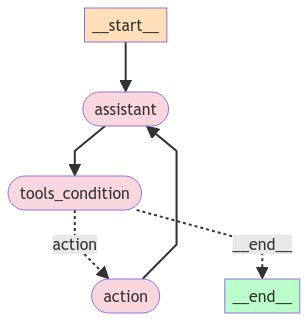

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

#### Example Conversation

Now it's time to try out our mighty chatbot! Let's run it over the following list of dialog turns. If it hits a "RecursionLimit", that means the agent wasn't able to get an answer in the allocated number of steps. That's OK! We have more tricks up our sleeve in later sections of this tutorial.

In [ ]:
import shutil
import uuid



tutorial_questions=[
    "سلام، پرواز من چه ساعتی است؟",
    "آیا می‌توانم پرواز خود را به زمانی زودتر تغییر دهم؟ می‌خواهم امروز دیرتر بروم.",
    "پروازم را به زمانی در هفته آینده تغییر دهید.",
    "اولین گزینه موجود عالی است.",
    "چه برنامه‌ای برای اقامت و حمل و نقل دارید؟",
    "بله فکر می‌کنم یک هتل با قیمت مناسب برای اقامت هفت روزه (7 روز) مناسب است. و می‌خواهم یک ماشین اجاره کنم.",
    "بسیار خوب، می‌توانید یک رزرو برای هتل پیشنهادی خودتان انجام دهید؟ به نظر خوب می‌آید.",
    "بله، هر چیزی که قیمت متوسط داشته باشد و در دسترس باشد را رزرو کنید.",
    "حالا برای ماشین، چه گزینه‌هایی دارم؟",
    "عالی است، ارزان‌ترین گزینه را بگیرید. برای 7 روز رزرو کنید.",
    "خیلی خوب، حالا چه پیشنهادهایی برای گردش دارید؟",
    "آیا آنها در زمانی که من آنجا هستم در دسترس هستند؟",
    "جالب است - من موزه‌ها را دوست دارم، چه گزینه‌هایی وجود دارد؟",
    "بسیار خوب، یکی را انتخاب کنید و برای روز دوم اقامتم رزرو کنید.",
]
# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "8499 420203",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


_printed = set()
for question in tutorial_questions:
    events = part_1_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

سلام، پرواز من چه ساعتی است؟
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_cXSsEMvzRFcI1B8F1bGwvh15)
 Call ID: call_cXSsEMvzRFcI1B8F1bGwvh15
  Args:
================================= Tool Message =================================
Name: fetch_user_flight_information

[{"ticket_no": "9880005432000988", "book_ref": "06B046", "flight_id": 28935, "flight_no": "OZ0059", "departure_airport": "BRU", "arrival_airport": "OSL", "scheduled_departure": "2024-03-31 06:14:03.561731-04:00", "scheduled_arrival": "2024-03-31 07:04:03.561731-04:00", "seat_no": "10E", "fare_conditions": "Economy"}]
================================== Ai Message ==================================

پرواز شما با شماره پرواز OZ0059 از فرودگاه BRU به فرودگاه OSL برای ساعت 06:14 صبح برنامه ریزی شده است.
================================ Human Message ===============

#### Part 1 Review


## Part 2: Add Confirmation



In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            passenger_id = config.get("passenger_id", None)
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful Persian customer support assistant for Swiss Airlines that provides concise and clear answers."
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_2_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    update_ticket_to_new_flight,
    cancel_ticket,
    search_car_rentals,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    search_hotels,
    book_hotel,
    update_hotel,
    cancel_hotel,
    search_trip_recommendations,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
part_2_assistant_runnable = assistant_prompt | llm.bind_tools(part_2_tools)

#### Define Graph


In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_2_assistant_runnable))
builder.add_node("action", create_tool_node_with_fallback(part_2_tools))
builder.add_edge("fetch_user_info", "assistant")
builder.add_conditional_edges(
    "assistant", tools_condition, {"action": "action", END: END}
)
builder.add_edge("action", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_2_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "action" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["action"],
)

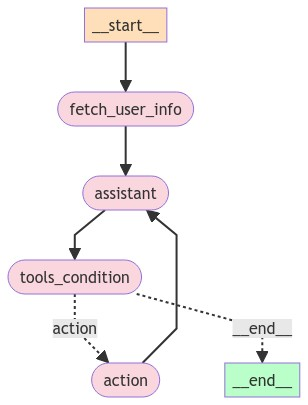

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_2_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

#### Example Conversation

Now it's time to try out our newly revised chatbot! Let's run it over the following list of dialog turns.

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "8499 420203",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}
tutorial_questions= [
"گزینه بعدی که موجود است عالی است",
"در مورد اقامت و حمل و نقل چطور؟ بله، فکر می‌کنم یک هتل مقرون‌به‌صرفه برای اقامت یک هفته‌ای (۷ روز) مناسب باشد. و می‌خواهم یک ماشین اجاره کنم.",
"خیلی خوب، می‌توانید برای هتلی که توصیه می‌کنید، رزرو کنید؟ به نظر خوب می‌آید.",
"بله، هر چیزی که هزینه متوسطی دارد و موجود است را رزرو کنید.",
"حالا برای ماشین، چه گزینه‌هایی دارم؟",
"عالی است، ارزان‌ترین گزینه را رزرو کنید. برای ۷ روز رزرو کنید.",
"خیلی خوب، حالا چه توصیه‌هایی برای گشت و گذار دارید؟",
"آیا این‌ها در زمانی که من آنجا هستم موجود هستند؟",
"جالب است - من موزه‌ها را دوست دارم، چه گزینه‌هایی وجود دارد؟ خیلی خوب، یکی را انتخاب کنید و برای روز دوم اقامتم رزرو کنید."
]

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_2_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_2_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        user_input = input(
"آیا با اقدامات فوق موافقید؟ برای ادامه 'y' تایپ کنید؛"
" در غیر این صورت، تغییرات درخواست‌شده خود را توضیح دهید.\n\n"
)
        if user_input.strip() == "y":
            # Just continue
            result = part_2_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_2_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_2_graph.get_state(config)

================================ Human Message =================================

گزینه بعدی که موجود است عالی است
================================== Ai Message ==================================
Tool Calls:
  fetch_user_flight_information (call_N3hESXY6m1Lni9YHAhJqgYND)
 Call ID: call_N3hESXY6m1Lni9YHAhJqgYND
  Args:
آیا با اقدامات فوق موافقید؟ برای ادامه 'y' تایپ کنید؛ در غیر این صورت، تغییرات درخواست‌شده خود را توضیح دهید.

y
================================ Human Message =================================

در مورد اقامت و حمل و نقل چطور؟ بله، فکر می‌کنم یک هتل مقرون‌به‌صرفه برای اقامت یک هفته‌ای (۷ روز) مناسب باشد. و می‌خواهم یک ماشین اجاره کنم.
================================== Ai Message ==================================
Tool Calls:
  search_hotels (call_oCngkDq3cKvo7QZpSGcKD8Z1)
 Call ID: call_oCngkDq3cKvo7QZpSGcKD8Z1
  Args:
    price_tier: Midscale
    checkin_date: 2024-05-15
    checkout_date: 2024-05-22
  search_car_rentals (call_u4FDglW8jZTEg5fSvVu7dXdw)
 Call ID: call_u4

## Part 3: Conditional Interrupt



In [ ]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig
from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}



assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful Persian customer support assistant for Swiss Airlines that provides concise and clear answers. "
            " Use the provided tools to search for flights, company policies, and other information to assist the user's queries. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())


# "Read"-only tools (such as retrievers) don't need a user confirmation to use
part_3_safe_tools = [
    TavilySearchResults(max_results=1),
    fetch_user_flight_information,
    search_flights,
    lookup_policy,
    search_car_rentals,
    search_hotels,
    search_trip_recommendations,
]

# These tools all change the user's reservations.
# The user has the right to control what decisions are made
part_3_sensitive_tools = [
    update_ticket_to_new_flight,
    cancel_ticket,
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
    book_hotel,
    update_hotel,
    cancel_hotel,
    book_excursion,
    update_excursion,
    cancel_excursion,
]
sensitive_tool_names = {t.name for t in part_3_sensitive_tools}
# Our LLM doesn't have to know which nodes it has to route to. In its 'mind', it's just invoking functions.
part_3_assistant_runnable = assistant_prompt | llm.bind_tools(
    part_3_safe_tools + part_3_sensitive_tools
)

#### Define Graph

Now, create the graph. Our graph is almost identical to part 2 **except** we split out the tools into 2 separate nodes. We only interrupt before the tools that are actually making changes to the user's bookings.

In [ ]:
from typing import Literal

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


# NEW: The fetch_user_info node runs first, meaning our assistant can see the user's flight information without
# having to take an action
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_3_assistant_runnable))
builder.add_node("safe_tools", create_tool_node_with_fallback(part_3_safe_tools))
builder.add_node(
    "sensitive_tools", create_tool_node_with_fallback(part_3_sensitive_tools)
)
# Define logic
builder.add_edge("fetch_user_info", "assistant")


def route_tools(state: State) -> Literal["safe_tools", "sensitive_tools", "__end__"]:
    next_node = tools_condition(state)
    # If no tools are invoked, return to the user
    if next_node == END:
        return END
    ai_message = state["messages"][-1]
    # This assumes single tool calls. To handle parallel tool calling, you'd want to
    # use an ANY condition
    first_tool_call = ai_message.tool_calls[0]
    if first_tool_call["name"] in sensitive_tool_names:
        return "sensitive_tools"
    return "safe_tools"


builder.add_conditional_edges(
    "assistant",
    route_tools,
)
builder.add_edge("safe_tools", "assistant")
builder.add_edge("sensitive_tools", "assistant")

memory = SqliteSaver.from_conn_string(":memory:")
part_3_graph = builder.compile(
    checkpointer=memory,
    # NEW: The graph will always halt before executing the "action" node.
    # The user can approve or reject (or even alter the request) before
    # the assistant continues
    interrupt_before=["sensitive_tools"],
)

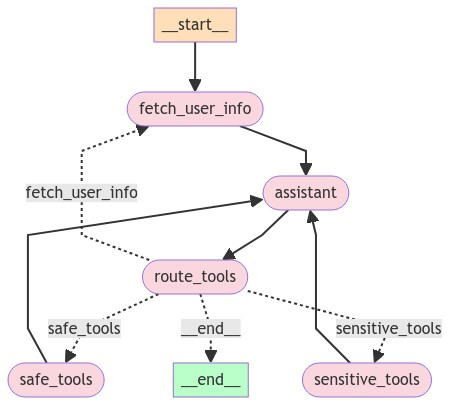

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_3_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

#### Example Conversation

Now it's time to try out our newly revised chatbot! Let's run it over the following list of dialog turns. This time, we'll have many fewer confirmations.

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "8499 420203",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}


tutorial_questions = [
    "باشه، میشه برای هتلی که توصیه کردید رزرو انجام بدید؟ به نظر خوب میاد.",
    "بله، ادامه بدید و هر چیزی که هزینه متوسطی داشته باشه و موجود باشه رزرو کنید.",
    "حالا برای ماشین، چه گزینه‌هایی دارم؟",
    "عالیه، بیایید ارزان‌ترین گزینه رو انتخاب کنیم. برای 7 روز رزرو کنید.",
    "عالیه، حالا چه توصیه‌هایی برای گردش دارید؟",
    "آیا این‌ها در زمانی که من اونجا هستم در دسترس هستند؟",
    "جالبه - من موزه‌ها رو دوست دارم، چه گزینه‌هایی وجود دارند؟",
    "باشه، یکی رو انتخاب کنید و برای روز دوم من اونجا رزرو کنید."
]
_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_3_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = part_3_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        input(
            "آیا اقدامات فوق را تأیید می‌کنید؟ برای ادامه 'y' تایپ کنید؛"
            " در غیر این صورت، تغییرات درخواستی خود را توضیح دهید.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue
            result = part_3_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = part_3_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_3_graph.get_state(config)

================================ Human Message =================================

باشه، میشه برای هتلی که توصیه کردید رزرو انجام بدید؟ به نظر خوب میاد.
================================== Ai Message ==================================
Tool Calls:
  search_trip_recommendations (call_uP8ONGiSN9kG44bJY64NuSab)
 Call ID: call_uP8ONGiSN9kG44bJY64NuSab
  Args:
    keywords: hotel
================================= Tool Message =================================
Name: search_trip_recommendations

[]
================================== Ai Message ==================================

با توجه به جستجوها، پیشنهاد خاصی برای هتل موجود نیست. آیا مایلید جستجوی دیگری انجام دهم؟
================================ Human Message =================================

بله، ادامه بدید و هر چیزی که هزینه متوسطی داشته باشه و موجود باشه رزرو کنید.
================================== Ai Message ==================================
Tool Calls:
  search_hotels (call_yZiNv3h1PJnMOo1fYAjKvVBT)
 Call ID: call_yZiNv3h1PJnMOo1fYAjK

## Part 4: Specialized Workflows



In [ ]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_car_rental",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

#### Assistants


In [ ]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }


# Flight booking assistant

flight_booking_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized Persian assistant for handling flight updates that provides concise and clear answers. "
            " The primary assistant delegates work to you whenever the user needs help updating their bookings. "
            "Confirm the updated flight details with the customer and inform them of any additional fees. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\n\nCurrent user flight information:\n\n{user_info}\n"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

update_flight_safe_tools = [search_flights]
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    update_flight_tools + [CompleteOrEscalate]
)

# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized Persain  assistant for handling hotel bookings that provides concise and clear answers. "
            "The primary assistant delegates work to you whenever the user needs help booking a hotel. "
            "Search for available hotels based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Hotel booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_hotel_safe_tools = [search_hotels]
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    book_hotel_tools + [CompleteOrEscalate]
)

# Car Rental Assistant
book_car_rental_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized Persian assistant for handling car rental bookings that provides concise and clear answers."
            "The primary assistant delegates work to you whenever the user needs help booking a car rental. "
            "Search for available car rentals based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_car_rental_safe_tools = [search_car_rentals]
book_car_rental_sensitive_tools = [
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
]
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    book_car_rental_tools + [CompleteOrEscalate]
)

# Excursion Assistant

book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized Persain assistant for handling trip recommendations that provides concise and clear answers. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Excursion booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

book_excursion_safe_tools = [search_trip_recommendations]
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    book_excursion_tools + [CompleteOrEscalate]
)


# Primary Assistant
class ToFlightBookingAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle flight updates and cancellations."""

    request: str = Field(
        description="Any necessary followup questions the update flight assistant should clarify before proceeding."
    )


class ToBookCarRental(BaseModel):
    """Transfers work to a specialized assistant to handle car rental bookings."""

    location: str = Field(
        description="The location where the user wants to rent a car."
    )
    start_date: str = Field(description="The start date of the car rental.")
    end_date: str = Field(description="The end date of the car rental.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the car rental."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Basel",
                "start_date": "2023-07-01",
                "end_date": "2023-07-05",
                "request": "I need a compact car with automatic transmission.",
            }
        }


class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(description="The check-in date for the hotel.")
    checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Zurich",
                "checkin_date": "2023-08-15",
                "checkout_date": "2023-08-20",
                "request": "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfers work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description="The location where the user wants to book a recommended trip."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip recommendation."
    )

    class Config:
        schema_extra = {
            "example": {
                "location": "Lucerne",
                "request": "The user is interested in outdoor activities and scenic views.",
            }
        }


llm = ChatOpenAI(model="gpt-3.5-turbo",temperature=1)
primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful Persian customer support assistant for Swiss Airlines that provides concise and clear answers."
            "Your primary role is to search for flight information and company policies to answer customer queries. "
            "If a customer requests to update or cancel a flight, book a car rental, book a hotel, or get trip recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user flight information:\n\n{user_info}\n"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())
primary_assistant_tools = [
    TavilySearchResults(max_results=1),
    search_flights,
    lookup_policy,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToFlightBookingAssistant,
        ToBookCarRental,
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

#### Create Assistant


In [ ]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        print(tool_call_id,assistant_name)
        return {
            "messages": [
                ToolMessage(
                    content=f"The Persain assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

#### Define Graph

Now it's time to start building our graph. As before, we'll start with a node to pre-populate the state with the user's current information.

In [ ]:
from typing import Literal

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")

In [ ]:
# Flight booking assistant
builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Updates & Booking Assistant", "update_flight"),
)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_edge("enter_update_flight", "update_flight")
builder.add_node(
    "update_flight_sensitive_tools",
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    "update_flight_safe_tools",
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(
    state: State,
) -> Literal[
    "update_flight_sensitive_tools",
    "update_flight_safe_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    return "update_flight_sensitive_tools"


builder.add_edge("update_flight_sensitive_tools", "update_flight")
builder.add_edge("update_flight_safe_tools", "update_flight")
builder.add_conditional_edges("update_flight", route_update_flight)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

Next, create the **car rental assistant** graph to own all car rental needs.

In [ ]:
# Car rental assistant

builder.add_node(
    "enter_book_car_rental",
    create_entry_node("Car Rental Assistant", "book_car_rental"),
)
builder.add_node("book_car_rental", Assistant(book_car_rental_runnable))
builder.add_edge("enter_book_car_rental", "book_car_rental")
builder.add_node(
    "book_car_rental_safe_tools",
    create_tool_node_with_fallback(book_car_rental_safe_tools),
)
builder.add_node(
    "book_car_rental_sensitive_tools",
    create_tool_node_with_fallback(book_car_rental_sensitive_tools),
)


def route_book_car_rental(
    state: State,
) -> Literal[
    "book_car_rental_safe_tools",
    "book_car_rental_sensitive_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_car_rental_safe_tools"
    return "book_car_rental_sensitive_tools"


builder.add_edge("book_car_rental_sensitive_tools", "book_car_rental")
builder.add_edge("book_car_rental_safe_tools", "book_car_rental")
builder.add_conditional_edges("book_car_rental", route_book_car_rental)

Then define the **hotel booking** workflow.

In [ ]:
# Hotel booking assistant
builder.add_node(
    "enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel")
)
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
) -> Literal[
    "leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", "__end__"
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges("book_hotel", route_book_hotel)

After that, define the **excursion assistant**.

In [ ]:
# Excursion assistant
builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_node(
    "book_excursion_safe_tools",
    create_tool_node_with_fallback(book_excursion_safe_tools),
)
builder.add_node(
    "book_excursion_sensitive_tools",
    create_tool_node_with_fallback(book_excursion_sensitive_tools),
)


def route_book_excursion(
    state: State,
) -> Literal[
    "book_excursion_safe_tools",
    "book_excursion_sensitive_tools",
    "leave_skill",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"


builder.add_edge("book_excursion_sensitive_tools", "book_excursion")
builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_conditional_edges("book_excursion", route_book_excursion)

Finally, create the **primary assistant**.

In [ ]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
) -> Literal[
    "primary_assistant_tools",
    "enter_update_flight",
    "enter_book_hotel",
    "enter_book_excursion",
    "__end__",
]:
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToFlightBookingAssistant.__name__:
            return "enter_update_flight"
        elif tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_book_car_rental"
        elif tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    {
        "enter_update_flight": "enter_update_flight",
        "enter_book_car_rental": "enter_book_car_rental",
        "enter_book_hotel": "enter_book_hotel",
        "enter_book_excursion": "enter_book_excursion",
        "primary_assistant_tools": "primary_assistant_tools",
        END: END,
    },
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "update_flight",
    "book_car_rental",
    "book_hotel",
    "book_excursion",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = SqliteSaver.from_conn_string(":memory:")
part_4_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "update_flight_sensitive_tools",
        "book_car_rental_sensitive_tools",
        "book_hotel_sensitive_tools",
        "book_excursion_sensitive_tools",
    ],
)

In [ ]:
from IPython.display import Image, display

try:
    display(Image(part_4_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

CompiledStateGraph(nodes={'__start__': PregelNode(config={'tags': ['langsmith:hidden']}, channels=['__start__'], triggers=['__start__'], writers=[ChannelWrite<messages,user_info,dialog_state>(recurse=True, writes=[ChannelWriteEntry(channel='messages', value=<object object at 0x7af6b807e9a0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='user_info', value=<object object at 0x7af6b807e9a0>, skip_none=False, mapper=_get_state_key(recurse=False)), ChannelWriteEntry(channel='dialog_state', value=<object object at 0x7af6b807e9a0>, skip_none=False, mapper=_get_state_key(recurse=False))]), ChannelWrite<start:fetch_user_info>(recurse=True, writes=[ChannelWriteEntry(channel='start:fetch_user_info', value='__start__', skip_none=False, mapper=None)])]), 'fetch_user_info': PregelNode(config={'tags': []}, channels={'messages': 'messages', 'user_info': 'user_info', 'dialog_state': 'dialog_state'}, triggers=['start:fetch_user_info', 'branch:update_flight:route_upda

#### Conversation

That was a lot! Let's run it over the following list of dialog turns. This time, we'll have many fewer confirmations.

In [ ]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
shutil.copy(backup_file, db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "8499 420203",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
              "خیلی خوب، پس الان بروزرسانی شد؟",
              "عالی - حالا می‌خواهم در مورد اقامت و حمل و نقل اطلاعات کسب کنم.",
              "بله فکر می‌کنم یک هتل مقرون به صرفه برای اقامت یک هفته‌ای (7 روزه) خوب باشد. و می‌خواهم یک ماشین کرایه کنم.",
              "بله لطفاً هر چیزی که هزینه متوسط دارد و در دسترس است را رزرو کن.",
              "حالا برای ماشین، چه گزینه‌هایی دارم؟",
              "عالیه، بیایید ارزان‌ترین گزینه را بگیریم. برو جلو و برای 7 روز رزرو کن.",
              "خوب، حالا چه توصیه‌هایی برای گشت و گذار دارید؟",
              "آیا آنها در حالی که من آنجا هستم در دسترس هستند؟",
              "جالب است - من به فعالیت‌های بیرون از خانه علاقه دارم. خوب، بیایید آن را برای روز دومم رزرو کنیم."
]

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = part_4_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:

        _print_event(event, _printed)
    snapshot = part_4_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        input(
            "آیا اقدامات فوق را تأیید می‌کنید؟ برای ادامه 'y' تایپ کنید؛"
            " در غیر این صورت، تغییرات درخواستی خود را توضیح دهید.\n\n"
        )
        if user_input.strip() == "y":
            # Just continue

            result = part_4_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            print(event["messages"][-1].tool_calls[0]["id"])
            result = part_4_graph.invoke(

                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = part_4_graph.get_state(config)

================================ Human Message =================================

خیلی خوب، پس الان بروزرسانی شد؟
================================== Ai Message ==================================

متاسفانه من نمی‌توانم به‌روزرسانی‌های پروازها را انجام دهم. برای درخواست به‌روزرسانی، باید به دستیار ویژه مربوطه مراجعه کنید. با استفاده از دستیاری که متخصص در افزایش و کنسلی پرواز است، می‌توانید اقدام لازم را انجام دهید. من می‌توانم شما را به این دستیار ویژه ارجاع دهم، اگر مایل هستید.
================================ Human Message =================================

عالی - حالا می‌خواهم در مورد اقامت و حمل و نقل اطلاعات کسب کنم.
================================== Ai Message ==================================
Tool Calls:
  ToBookCarRental (call_uveZTFrYkElYj5plDUkf18uQ)
 Call ID: call_uveZTFrYkElYj5plDUkf18uQ
  Args:
    location: OSL
    start_date: 2024-03-31
    end_date: 2024-04-05
    request: I need information about car rental options in Oslo during my stay.
  ToHotelBookingAssistant (ca

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_XClf8fsMArhs5jbsmoysetx6", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}